Libraries

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix

from utils import *

In [2]:
if not os.path.exists("./images"):
    os.mkdir("./images")

Store the audio files in numpy format

In [3]:
vectorize_audio("audio/", "vectorized_audio/")

Load the labels

In [4]:
labels_df = pd.read_csv("development.csv")

get_basic_features("vectorized_audio")
basic_features_df = pd.read_csv("basic_features.csv")
basic_features_df["filename"] = basic_features_df["filename"].map(lambda x: x.replace(".npy", ".wav"))
explore_df = labels_df.join(basic_features_df.set_index("filename"), on="filename")

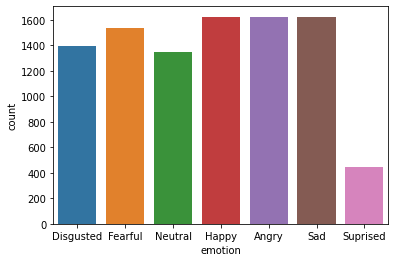

In [5]:
fig, ax = plt.subplots()
sns.countplot(x=labels_df["emotion"], ax=ax)
fig.savefig("images/label_counts.svg", format="svg")

Text(0, 0.5, 'peak amplitude [dB]')

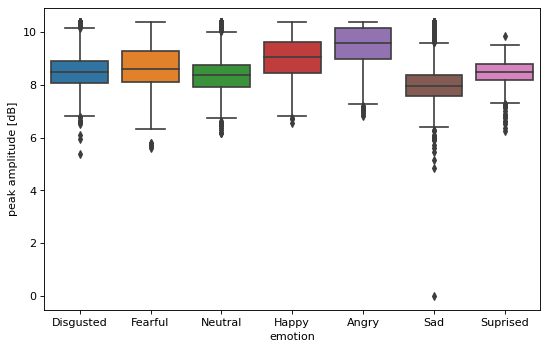

In [6]:
fig, ax = plt.subplots(figsize=(8,5), dpi=80)

ax = sns.boxplot(x=explore_df['emotion'], y = np.log(explore_df['peak_amplitude'] + 1))
ax.set_ylabel("peak amplitude [dB]")

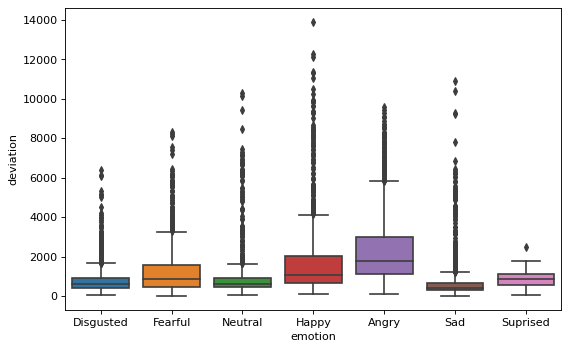

In [7]:
fig, ax = plt.subplots(figsize=(8,5), dpi=80)

ax = sns.boxplot(x=explore_df['emotion'], y = (explore_df['deviation']))

/home/zero/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


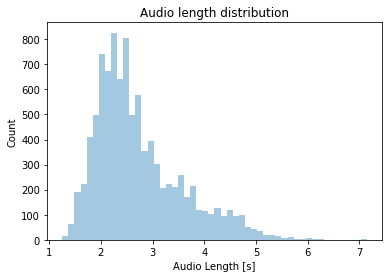

In [8]:
fig, ax = plt.subplots()
sns.distplot(explore_df['duration'], kde=False, ax=ax)

ax.set_title("Audio length distribution")
ax.set_xlabel("Audio Length [s]")
ax.set_ylabel("Count")
fig.savefig("images/audio_lengths.svg", format="svg")

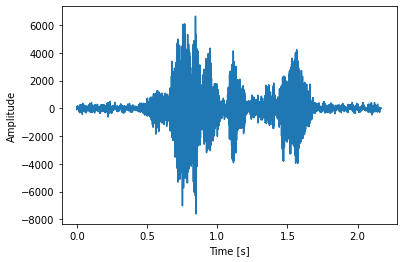

In [9]:
x0 = np.load("vectorized_audio/0.npy")
time_plot_audio(x0, save_as="images/time_domain.svg")

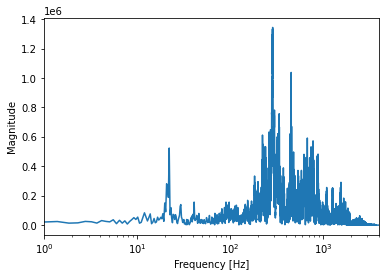

In [10]:
freq_plot_audio(x0, save_as="images/freq_domain.svg")

/home/zero/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


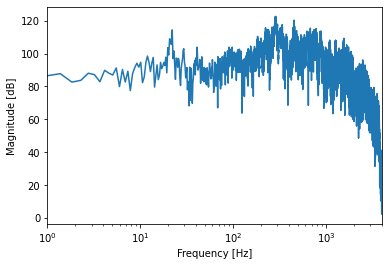

In [11]:
freq_plot_audio(x0, save_as="images/freq_domain_dB.svg", dB=True)

In [12]:
#spectrogramize_audio("vectorized_audio", "spectrograms", sample_rate=8000, file_type=".npy")  # default scipy settings
spectrogramize_audio("vectorized_audio", "spectrograms_shift10ms", noverlap=176, sample_rate=8000, file_type=".npy")

In [13]:
f, t, S0 = spectrogram(x0, fs=8000, nperseg=256, noverlap=176)
fd, td, S0d = spectrogram(x0, fs=8000, nperseg=256)

/home/zero/Masters/DSL/SER/utils.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(t, f, 10 * np.log10(S))


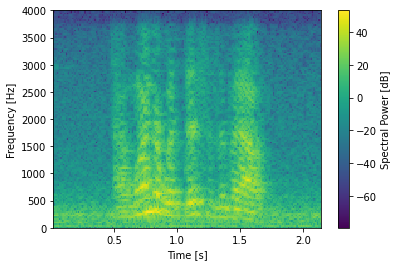

In [14]:
spec_plot_audio(t=t, f=f, S=S0, save_as="images/spectrogram.svg")

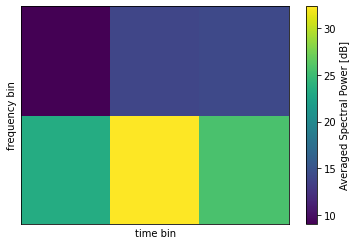

In [15]:
S_m, S_s = compress_spectrogram(S0, 2, 3)

fig, ax = plt.subplots()
im = plt.pcolormesh(10*np.log10(S_m))
ax.set_ylabel("frequency bin")
ax.set_xlabel("time bin")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(im)
cbar.set_label("Averaged Spectral Power [dB]")
fig.savefig("images/compressed_spectrogram_mean.svg", format="svg")

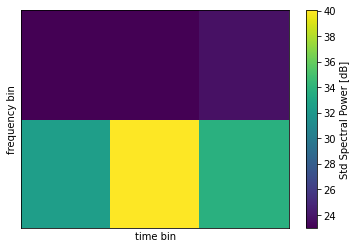

In [16]:
fig, ax = plt.subplots()
im = plt.pcolormesh(10*np.log10(S_s))
ax.set_ylabel("frequency bin")
ax.set_xlabel("time bin")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(im)
cbar.set_label("Std Spectral Power [dB]")
fig.savefig("images/compressed_spectrogram_std.svg", format="svg")

In [18]:
le = LabelEncoder().fit(labels_df["emotion"])
y = le.transform(labels_df["emotion"])

In [21]:
parameters = {"n_freq_bins": [2, 5, 15, 20], "n_time_bins": [2, 5, 10, 15, 30]}   
grid = ParameterGrid(parameters)
scores = dict()

for v in list(grid):
  print(v)
  get_spectral_features("spectrograms_shift10ms", **v)
  features_df = pd.read_csv(f"features/f{v['n_freq_bins']}_t{v['n_time_bins']}.csv")
  features_df["filename"] = features_df["filename"].map(lambda x: x.replace(".npy", ".wav"))
  train_df = labels_df.join(features_df.set_index("filename"), on="filename")

  X = train_df.iloc[:, 2:]


  clf = RandomForestClassifier()
  print(f"RF: {cross_val_score(clf, X, y, cv=5, scoring='f1_macro').mean()}")

  svm = make_pipeline(StandardScaler(), SVC())
  print(f"SVM: {cross_val_score(svm, X, y, cv=5, scoring='f1_macro').mean()}\n")

{'n_freq_bins': 2, 'n_time_bins': 2}
RF: 0.46566396017648176
SVM: 0.400800476455457

{'n_freq_bins': 2, 'n_time_bins': 5}
RF: 0.5639210949432971
SVM: 0.5368514600970204

{'n_freq_bins': 2, 'n_time_bins': 10}
RF: 0.5929093715435279
SVM: 0.5725698845186272

{'n_freq_bins': 2, 'n_time_bins': 15}
RF: 0.5935643110515864
SVM: 0.5768810751287218

{'n_freq_bins': 2, 'n_time_bins': 30}
RF: 0.5961042334324259
SVM: 0.5779904322406084

{'n_freq_bins': 5, 'n_time_bins': 2}
RF: 0.5827992974851269
SVM: 0.5699236530452729

{'n_freq_bins': 5, 'n_time_bins': 5}
RF: 0.6152960251807477
SVM: 0.6079021293298567

{'n_freq_bins': 5, 'n_time_bins': 10}
RF: 0.62714101210034
SVM: 0.6231590124552329

{'n_freq_bins': 5, 'n_time_bins': 15}
RF: 0.6199218021209234
SVM: 0.6223328939837224

{'n_freq_bins': 5, 'n_time_bins': 30}
RF: 0.6101395800742996
SVM: 0.6178721964911784

{'n_freq_bins': 15, 'n_time_bins': 2}
RF: 0.6220334517581982
SVM: 0.6135126684073138

{'n_freq_bins': 15, 'n_time_bins': 5}
RF: 0.6316285837706651

In [22]:
features_df = pd.read_csv(f"features/f{20}_t{10}.csv")
features_df["filename"] = features_df["filename"].map(lambda x: x.replace(".npy", ".wav"))
df = labels_df.join(features_df.set_index("filename"), on="filename")
X = df.iloc[:, 2:]

In [24]:
#RF
rf_param_grid = {
    "max_depth": [None, 10],
    "n_estimators": [50, 100, 150],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"]
}
# Create a based model
# Instantiate the grid search model
rf_grid_search = GridSearchCV(estimator = RandomForestClassifier(),
                              param_grid = rf_param_grid, 
                              scoring="f1_macro",
                              cv = 5,
                              n_jobs = -1,
                              verbose = 2)
rf_grid_search.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='f1_macro', verbose=2)

In [25]:
rf_grid_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_grid_results \
    .sort_values("rank_test_score") \
    .loc[:,["params","rank_test_score", "mean_test_score","std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
20,"{'class_weight': 'balanced', 'criterion': 'ent...",1,0.638503,0.009259
13,"{'class_weight': 'balanced', 'criterion': 'gin...",2,0.637656,0.012147
14,"{'class_weight': 'balanced', 'criterion': 'gin...",3,0.637172,0.006594
2,"{'class_weight': None, 'criterion': 'gini', 'm...",4,0.633416,0.018721
8,"{'class_weight': None, 'criterion': 'entropy',...",5,0.633193,0.008763
1,"{'class_weight': None, 'criterion': 'gini', 'm...",6,0.631310,0.007925
7,"{'class_weight': None, 'criterion': 'entropy',...",7,0.631299,0.017026
19,"{'class_weight': 'balanced', 'criterion': 'ent...",8,0.630141,0.013001
0,"{'class_weight': None, 'criterion': 'gini', 'm...",9,0.624200,0.007821
6,"{'class_weight': None, 'criterion': 'entropy',...",10,0.619819,0.017094


In [39]:
rf_grid_results.loc[20, "params"]

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': None,
 'n_estimators': 150}

In [26]:
#SVM
steps = [
    ('scaler', StandardScaler()),
    ('svc', SVC(cache_size=2000))
]
svc_pipeline = Pipeline(steps)

svc_param_grid = {
    "svc__C": [0.01, 0.1, 1, 10, 100],
    "svc__gamma": ["scale", 0.1, 1, 10, 100],
    "svc__class_weight": [None, "balanced"]
}
# Create a based model
# Instantiate the grid search model
svc_grid_search = GridSearchCV(estimator = svc_pipeline,
                               param_grid = svc_param_grid,
                               scoring="f1_macro",
                               cv = 3,
                               n_jobs = -1,
                               verbose = 2)
svc_grid_search.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(cache_size=2000))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.01, 0.1, 1, 10, 100],
                         'svc__class_weight': [None, 'balanced'],
                         'svc__gamma': ['scale', 0.1, 1, 10, 100]},
             scoring='f1_macro', verbose=2)

In [27]:
svc_grid_results = pd.DataFrame(svc_grid_search.cv_results_)
svc_grid_results \
    .sort_values("rank_test_score") \
    .loc[:,["params","rank_test_score", "mean_test_score","std_test_score"]]

,params,rank_test_score,mean_test_score,std_test_score
30,"{'svc__C': 10, 'svc__class_weight': None, 'svc...",1,0.676362,0.006082
35,"{'svc__C': 10, 'svc__class_weight': 'balanced'...",2,0.675515,0.005213
45,"{'svc__C': 100, 'svc__class_weight': 'balanced...",3,0.666200,0.004062
40,"{'svc__C': 100, 'svc__class_weight': None, 'sv...",4,0.665662,0.003286
20,"{'svc__C': 1, 'svc__class_weight': None, 'svc_...",5,0.643211,0.002779
25,"{'svc__C': 1, 'svc__class_weight': 'balanced',...",6,0.622634,0.003532
10,"{'svc__C': 0.1, 'svc__class_weight': None, 'sv...",7,0.513731,0.008203
15,"{'svc__C': 0.1, 'svc__class_weight': 'balanced...",8,0.493098,0.006452
5,"{'svc__C': 0.01, 'svc__class_weight': 'balance...",9,0.249317,0.011153
0,"{'svc__C': 0.01, 'svc__class_weight': None, 's...",10,0.187149,0.002972


In [35]:
svc_grid_results.loc[30, "params"]

{'svc__C': 10, 'svc__class_weight': None, 'svc__gamma': 'scale'}

In [ ]:
# removed the predict phase for the evaluation set.